In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-hwr-ai-pro-intake1/sample_submission.csv
/kaggle/input/arabic-hwr-ai-pro-intake1/train.csv
/kaggle/input/arabic-hwr-ai-pro-intake1/test.csv
/kaggle/input/arabic-hwr-ai-pro-intake1/test/01301.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02578.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/00929.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02630.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/01883.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/00704.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/03163.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/01124.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/01570.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/03092.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02640.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02422.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02284.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/00562.png
/kaggle/input/arabic-hwr-ai-pro-intake1/test/02715.png
/kaggle/input/

In [2]:
## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from PIL import Image

## less Important
from functools import partial
import os
from scipy import stats
import missingno as msno
import joblib
import tarfile
import shutil
import urllib

## Sklearn
from sklearn import datasets
## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## Metrics
from sklearn.metrics import accuracy_score

## tensorflow & Keras
import tensorflow as tf    ## i will use tf for every thing and for keras using tf.keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
import cv2

## Loading the Data and Look at the Big Picture

`Only for training here`

In [3]:
train_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
train_images = Path(r'../input/arabic-hwr-ai-pro-intake1/train')

## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_images.glob(r'*.png'))), name='Filepath').astype(str)

train_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/train/00000...
1    ../input/arabic-hwr-ai-pro-intake1/train/00001...
2    ../input/arabic-hwr-ai-pro-intake1/train/00002...
3    ../input/arabic-hwr-ai-pro-intake1/train/00003...
4    ../input/arabic-hwr-ai-pro-intake1/train/00004...
Name: Filepath, dtype: object

## Explore the Data

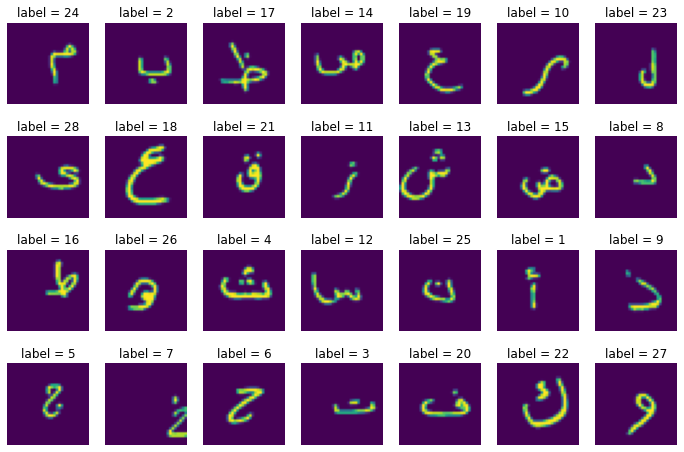

In [4]:
img_key_value = {}
for value in train_labels['label'].unique():
    img_key_value[value] = train_labels[train_labels['label']==value].index[0]
    
img_index = list(img_key_value.values())
img_label = list(img_key_value.keys())

fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}')
        img = plt.imread(train_images_paths.iloc[img_index[i]])
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [5]:
print('Number of Instances in train_set =>', len(train_images_paths))
print('Number of Instances in train_labels =>', len(train_labels))

print()

img = cv2.imread(train_images_paths.iloc[img_index[0]])
print('shape of each Image is =>', img.shape)

Number of Instances in train_set => 13440
Number of Instances in train_labels => 13440

shape of each Image is => (32, 32, 3)


## Data Preprocessing

In [6]:
train_full_labels = train_labels['label'].values
train_full_set = np.empty((13440, 32, 32,3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(train_images_paths):
    img = cv2.imread(path)
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV_FULL)
#     img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_hsv,(3,3), sigmaX=0, sigmaY=0)    
#     edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) 
    train_full_set[idx] = img_blur
    
print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)

train_full_set.shape => (13440, 32, 32, 3)
train_full_labels.shape => (13440,)


## Split the Data

In [7]:
# train_full_set = train_full_set/255.0

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_full_set, train_full_labels, 
                                                      test_size=0.05, shuffle=True, random_state=42,stratify = train_full_labels)

print('X_train.shape =>', X_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_train.shape =>', y_train.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (12768, 32, 32, 3)
X_valid.shape => (672, 32, 32, 3)
y_train.shape => (12768,)
y_valid.shape => (672,)


## Model Training

In [9]:
# #1D image
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu',input_shape=(32, 32)),
#     tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=1),
    
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=1),
    
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=1),
    
#     tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
#     tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=1),
    
#     tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
#     tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=1),
#     Dropout(0.5),
    
#     tf.keras.layers.GlobalAvgPool1D(),
#     tf.keras.layers.Dense(29, activation='softmax')
 
# ])

In [10]:
# 3-Channel image
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu',input_shape=(32, 32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=1),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=1),
    

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=1),
    

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    Dropout(0.5),
    
    

    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(29, activation='softmax')
 
])

2021-11-07 18:02:05.366738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:02:05.450659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:02:05.451358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 18:02:05.453087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint                                     
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1,
                               monitor='val_accuracy', mode='max', save_best_only=True)

early_stopp = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train)

In [14]:
# data augementation using model.fit_generator()

model.fit_generator(datagen.flow(X_train,y_train, batch_size=64),
                             epochs = 200,callbacks=[checkpointer], validation_data=(X_valid, y_valid))
# history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
#                     epochs=60, batch_size=64, callbacks=[checkpointer])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-07 18:02:08.240041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-07 18:02:09.608115: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 14s 38ms/step - loss: 5.3537 - accuracy: 0.2575 - val_loss: 1.6632 - val_accuracy: 0.5446

Epoch 00001: val_accuracy improved from -inf to 0.54464, saving model to weights.hdf5
Epoch 2/200
200/200 [==============================] - 7s 34ms/step - loss: 1.2165 - accuracy: 0.5966 - val_loss: 0.8448 - val_accuracy: 0.7827

Epoch 00002: val_accuracy improved from 0.54464 to 0.78274, saving model to weights.hdf5
Epoch 3/200
200/200 [==============================] - 7s 35ms/step - loss: 0.7583 - accuracy: 0.7535 - val_loss: 0.5206 - val_accuracy: 0.8839

Epoch 00003: val_accuracy improved from 0.78274 to 0.88393, saving model to weights.hdf5
Epoch 4/200
200/200 [==============================] - 7s 36ms/step - loss: 0.5730 - accuracy: 0.8174 - val_loss: 0.4221 - val_accuracy: 0.9107

Epoch 00004: val_accuracy improved from 0.88393 to 0.91071, saving model to weights.hdf5
Epoch 5/200
200/200 [==============================] - 7s 36ms/step - loss: 0.

In [15]:
# pd.DataFrame(history.history).plot(figsize=(10, 6));

In [16]:
# loss_all_data, acc_all_data = model.evaluate(train_full_set, train_full_labels, verbose=0)
# Loading the best weights
model.load_weights('weights.hdf5')   

# training accuracy of our model
print("training accuracy: {}".format(model.evaluate(X_train, y_train)))

# Evaluating our model
print("validation accuracy: {}".format(model.evaluate(X_valid, y_valid)))
# print('loss_all_data =>', loss_all_data)
# print('acc_all_data =>', acc_all_data)

399/399 [==============================] - 1s 2ms/step - loss: 0.0234 - accuracy: 0.9939
training accuracy: [0.02341797761619091, 0.9938910007476807]
21/21 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.9851
validation accuracy: [0.08019007742404938, 0.9851190447807312]


## Evaluation on Testing DataSet

In [17]:
test_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')
test_images = Path(r'../input/arabic-hwr-ai-pro-intake1/test')

## read these all training images paths as Series
test_images_paths = pd.Series(sorted(list(test_images.glob(r'*.png'))), name='Filepath').astype(str)

test_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/test/00000.png
1    ../input/arabic-hwr-ai-pro-intake1/test/00001.png
2    ../input/arabic-hwr-ai-pro-intake1/test/00002.png
3    ../input/arabic-hwr-ai-pro-intake1/test/00003.png
4    ../input/arabic-hwr-ai-pro-intake1/test/00004.png
Name: Filepath, dtype: object

In [18]:
print('Number of Instances in test_set is', len(test_images_paths))

Number of Instances in test_set is 3360


In [19]:
test_full_set = np.empty((3360, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(test_images_paths):
    img = cv2.imread(path)
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV_FULL)
    img_blur = cv2.GaussianBlur(img_hsv,(3,3), sigmaX=0, sigmaY=0)    
    test_full_set[idx] = img_blur
    
print('test_full_set.shape =>', test_full_set.shape)

test_full_set.shape => (3360, 32, 32, 3)


In [20]:
y_preds_classes = np.argmax(model.predict(test_full_set), axis=-1)

In [21]:
test_labels['label'] = y_preds_classes

In [22]:
test_labels

,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


In [23]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)

## Done :D